In [4]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [8]:
cd /content/gdrive/MyDrive/Detection/simple-ssd-for-beginners/

/content/gdrive/MyDrive/Detection/simple-ssd-for-beginners


In [43]:
from voc_dataset import CustomDetection
from config import opt
import numpy as np
from lib.model import SSD
import torch
import torch.nn.functional as F
import os
from lib.utils import detection_collate 
from lib.multibox_encoder import MultiBoxEncoder
from lib.ssd_loss import MultiBoxLoss
import cv2
from lib.utils import nms
from lib.augmentations import preproc_for_test
import matplotlib.pyplot as plt
from lib.utils import detect


%matplotlib inline



In [32]:
# CLASSES = ('어린이 보호', '직진금지', '좌회전 및 U턴', '좌회전', '통행금지', '우회로', '우회전', '회전형 교차로', '철길건널목', '직진')
CLASSES = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

### load model

In [33]:
model = SSD(opt.num_classes, opt.anchor_num)
state_dict = torch.load('weights/loss-121.17.pth', map_location='cpu')
model.load_state_dict(state_dict)

<All keys matched successfully>

### anchors

In [34]:
multibox_encoder = MultiBoxEncoder(opt)

### load and preprocess image

In [35]:
image = '/content/gdrive/MyDrive/Detection/VirtualTrafficSignDetectionDB/images/2019_08_07_11_25_28_787_264_200.png'
src = cv2.imread(image, cv2.IMREAD_COLOR)
image = preproc_for_test(src, opt.min_size, opt.mean)
image = torch.from_numpy(image)

### predict

In [36]:
with torch.no_grad():
    loc, conf = model(image.unsqueeze(0))

### convert torch ----> numpy

In [37]:
loc = loc[0]
conf = conf[0]
conf = F.softmax(conf, dim=1)
conf = conf.numpy()
loc = loc.numpy()

### decode location

In [38]:
decode_loc = multibox_encoder.decode(loc)

### detect

In [39]:
gt_boxes, gt_confs, gt_labels = detect(decode_loc, conf, nms_threshold=0.45, gt_threshold=0.1)

### map locations back to original image

In [40]:
h, w = src.shape[:2]
gt_boxes[:, 0] = gt_boxes[:, 0] * w
gt_boxes[:, 1] = gt_boxes[:, 1] * h
gt_boxes[:, 2] = gt_boxes[:, 2] * w
gt_boxes[:, 3] = gt_boxes[:, 3] * h
gt_boxes = gt_boxes.astype(int)

### show

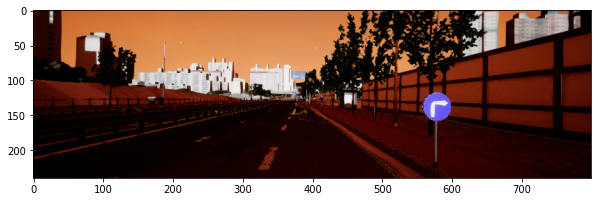

In [41]:
plt.figure(figsize=(10, 10))
plt.imshow(src[:, :, ::-1])

6 0.9856442 559 117 599 166


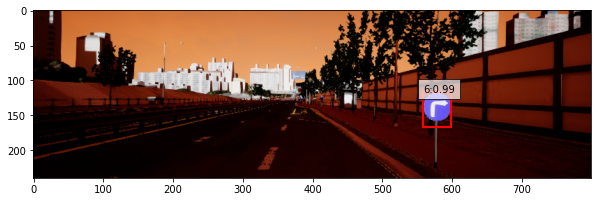

In [42]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
ax.imshow(src[:, :, ::-1])
for box, label, score in zip(gt_boxes, gt_labels, gt_confs):
        print(label, score, *box)
        if score > 0.4:
            text = '{:s}:{:.2f}'.format(CLASSES[label], score)
            ax.add_patch(
                plt.Rectangle(
                (box[0], box[1]), 
                 box[2] - box[0], 
                 box[3] - box[1],
                 fill=False, 
                 edgecolor='red',
                 linewidth=2)
            )
            ax.text(box[0], box[1], text,
                    bbox={'facecolor' : 'white', 'alpha' : 0.7, 'pad' : 5}
                   )
plt.savefig('images/2.jpg')